<a href="https://colab.research.google.com/github/mmartamagna/Plant-leaves-classification-AMD/blob/main/Project_Plant_Leaves_Magnani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant leaves recognizer with deep learning
### *Marta Magnani (961071) - Università degli Studi di Milano*

Project for the module **Algoritms for Massive Data** of the course Algoritms for Massive Data, Cloud and Distributed Computing for the academic year 2022-2023. The task is to implement a deep-learning-based system classifying pictures of leaves according to the twelve types of plants using the «Plant leaves» dataset. The «Plant leaves» dataset is published on Kaggle and released under the Community Data License Agreement – Sharing, Version 1.0.

Here the data: https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification

# Libraries and data download

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
seed=856
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

# Enable GPU(s) for TensorFlow (I remove this to fasten the computations)
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Comment out or remove this line

# Verify available GPU devices
print(f"Available GPU(s): {tf.config.list_physical_devices('GPU')}")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import datetime
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pickle
import pathlib

# OpenCV (Open Source Computer Vision Library: http://opencv.org) is an open-source library that includes
# several hundreds of computer vision algorithms for image operations.
import cv2

# tensorflow is the library used for deep learning
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# visualkeras to get a pretty visualization of neural networks architectures
# https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network

# PIL for image preprocessing
import PIL
import PIL.Image

# Neural Networks
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy


# Cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, zero_one_loss
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier

tfk = tf.keras
#tf.keras.backend.set_floatx("float64")
%load_ext tensorboard

In [3]:
# if you want to specify your own username-key, just change it
os.environ["KAGGLE_USERNAME"] = "XXXXXX"
os.environ["KAGGLE_KEY"] = "XXXXXXXXX"

In [4]:
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

100% 6.56G/6.56G [05:39<00:00, 22.9MB/s]
100% 6.56G/6.56G [05:39<00:00, 20.8MB/s]


In [5]:
# silently unzip the folder just downloaded
!unzip -q plant-leaves-for-image-classification.zip
!ls

plant-leaves-for-image-classification.zip  Plants_2  sample_data


In [6]:
# Set the folder names
train_folder = "Plants_2/train"
validation_folder = "Plants_2/valid"
test_folder = "Plants_2/test"

# Function to count files in a folder
def count_files(folder_path):
    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# Count files in each folder
train_count = count_files(train_folder)
validation_count = count_files(validation_folder)
test_count = count_files(test_folder)

# Print the results
print("Number of files in train folder:", train_count)
print("Number of files in validation folder:", validation_count)
print("Number of files in test folder:", test_count)

Number of files in train folder: 4274
Number of files in validation folder: 110
Number of files in test folder: 110


# Data preprocessing
Data preprocessing refers to the steps and techniques applied to raw data before it is used for analysis or modeling tasks. It involves transforming the raw data into a format that is more suitable and understandable for machine learning algorithms or other data analysis techniques. Data preprocessing is an essential step in the data pipeline as it helps to improve the quality, reliability, and effectiveness of the subsequent analysis or modeling processes. In this section, images from train, test and validation sets are resized to 128x128 and pixels are normalized (/255.0).

In the code below, images and labels are separated (in train, validation and test sets) and stored into Numpy arrays. In particular, we have three different labels array according to the aim fo the CNNs:
- y_xxxx_binary (contains only two labels for diseased and healthy)
- y_xxxx_species (contains only the 12 species of leaves)
- y_xxxx_complete (contains the 22 complete labels, e.g. Mango Healthy)

In [7]:
# Define two lists, complete_names contains the complete original names of images, species_list contains only the 12 species
complete_names = ['Alstonia Scholaris diseased (P2a)',
              'Alstonia Scholaris healthy (P2b)',
              'Arjun diseased (P1a)',
              'Arjun healthy (P1b)',
              'Bael diseased (P4b)',
              'Basil healthy (P8)',
              'Chinar diseased (P11b)',
              'Chinar healthy (P11a)',
              'Gauva diseased (P3b)',
              'Gauva healthy (P3a)',
              'Jamun diseased (P5b)',
              'Jamun healthy (P5a)',
              'Jatropha diseased (P6b)',
              'Jatropha healthy (P6a)',
              'Lemon diseased (P10b)',
              'Lemon healthy (P10a)',
              'Mango diseased (P0b)',
              'Mango healthy (P0a)',
              'Pomegranate diseased (P9b)',
              'Pomegranate healthy (P9a)',
              'Pongamia Pinnata diseased (P7b)',
              'Pongamia Pinnata healthy (P7a)']

species_list = ['Alstonia Scholaris', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

In [8]:
import cv2
import os

X_train, y_train_binary, y_train_species, y_train_complete = [], [], [], []

for directory in complete_names:
    dir_path = os.path.join(train_folder, directory)
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, file_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))
            image = image / 255.0  # Normalize the image pixel values
            X_train.append(image)

            species = next((species for species in species_list if species in directory), None)

            y_train_binary.append(0 if 'healthy' in directory else 1)
            y_train_species.append(species)
            y_train_complete.append(directory)

X_train = np.array(X_train)
y_train_binary = np.array(y_train_binary)
y_train_species = np.array(y_train_species)
y_train_complete = np.array(y_train_complete)

In [9]:
##Check what is contained in the y arrays
print(y_train_binary)
print(y_train_species)
print(y_train_complete)

[1 1 1 ... 0 0 0]
['Alstonia Scholaris' 'Alstonia Scholaris' 'Alstonia Scholaris' ...
 'Pongamia Pinnata' 'Pongamia Pinnata' 'Pongamia Pinnata']
['Alstonia Scholaris diseased (P2a)' 'Alstonia Scholaris diseased (P2a)'
 'Alstonia Scholaris diseased (P2a)' ... 'Pongamia Pinnata healthy (P7a)'
 'Pongamia Pinnata healthy (P7a)' 'Pongamia Pinnata healthy (P7a)']


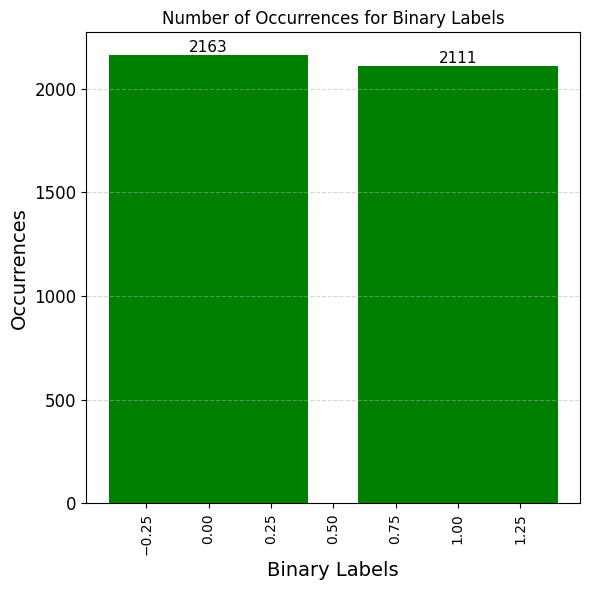

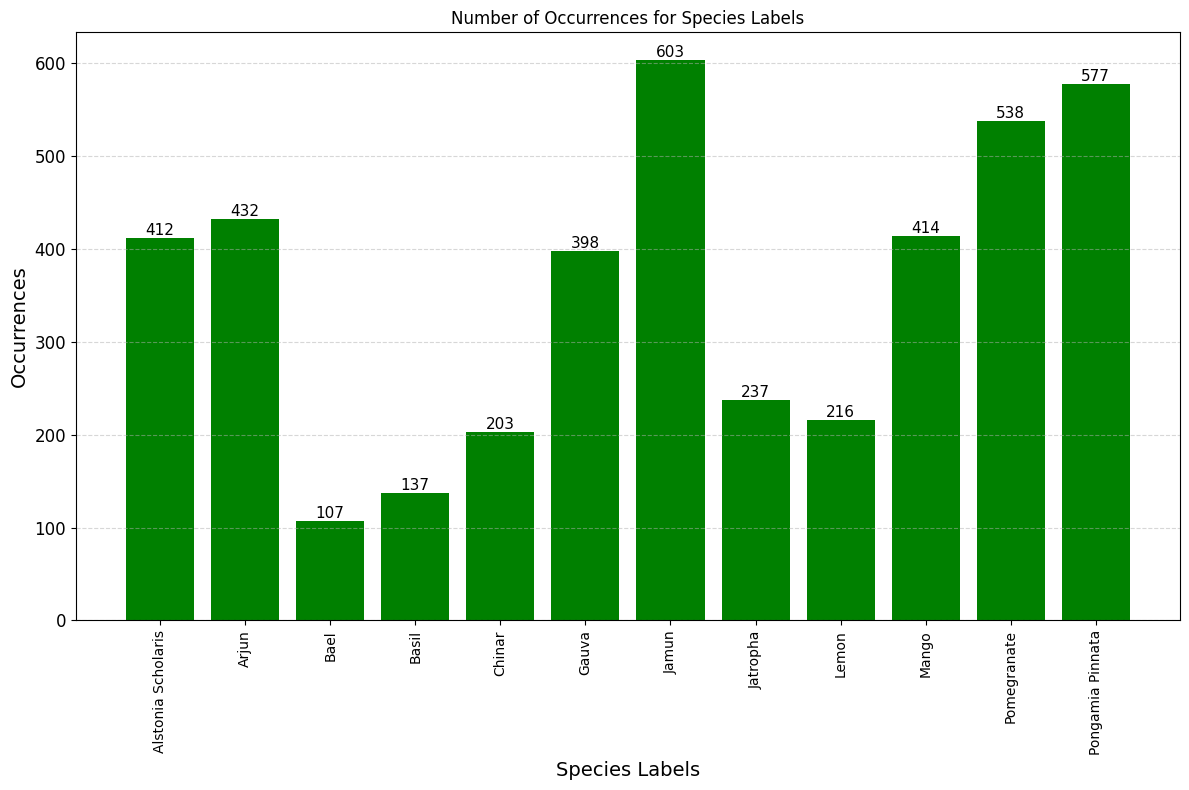

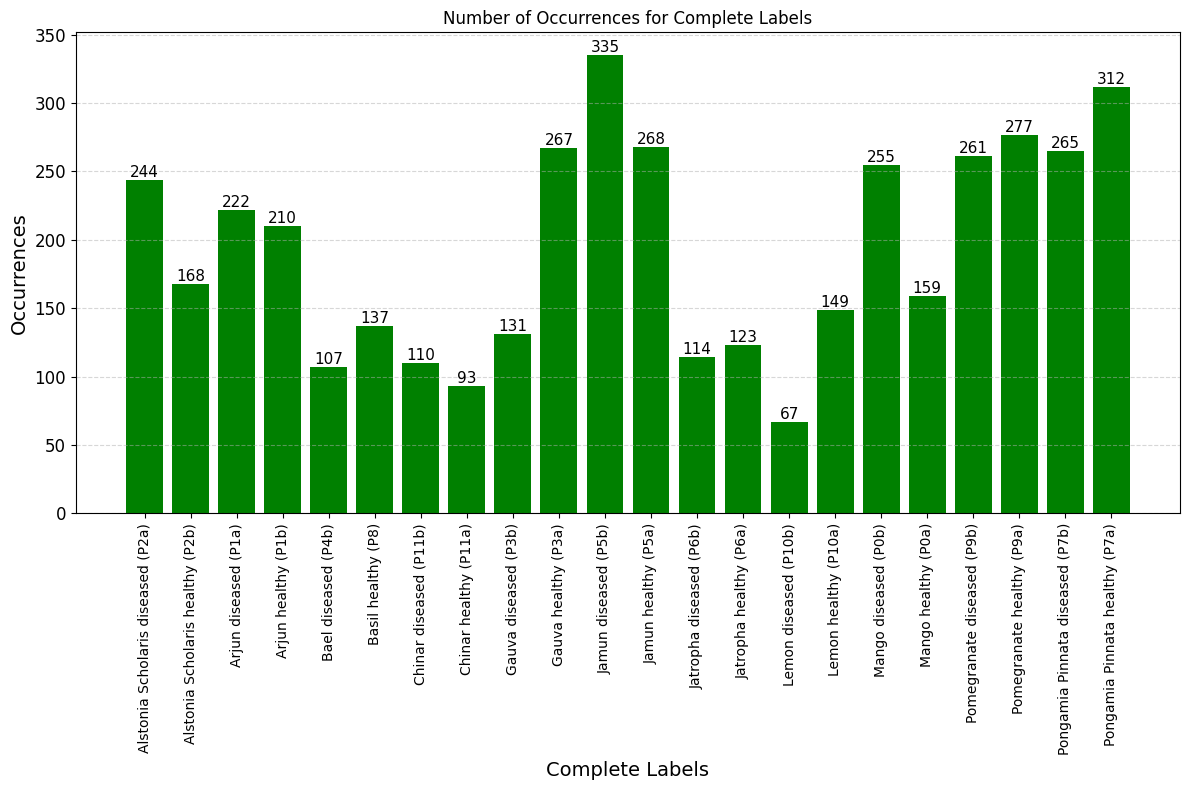

In [41]:
unique_labels_binary, counts_binary = np.unique(y_train_binary, return_counts=True)
unique_labels_species, counts_species = np.unique(y_train_species, return_counts=True)
unique_labels_complete, counts_complete = np.unique(y_train_complete, return_counts=True)

import matplotlib.pyplot as plt
# Plotting the number of occurrences for binary labels
plt.figure(figsize=(6, 6))
plt.bar(unique_labels_binary, counts_binary, color='green')
plt.xlabel("Binary Labels", fontsize=14)
plt.ylabel("Occurrences", fontsize=14)
plt.title("Number of Occurrences for Binary Labels", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add numbers on top of the bars
for i, count in enumerate(counts_binary):
    plt.text(i, count, str(count), ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

# Plotting the number of occurrences for species labels
plt.figure(figsize=(12, 8))
plt.bar(unique_labels_species, counts_species, color='green')
plt.xlabel("Species Labels", fontsize=14)
plt.ylabel("Occurrences", fontsize=14)
plt.title("Number of Occurrences for Species Labels", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add numbers on top of the bars
for i, count in enumerate(counts_species):
    plt.text(i, count, str(count), ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

# Plotting the number of occurrences for complete labels
plt.figure(figsize=(12, 8))
plt.bar(unique_labels_complete, counts_complete, color='green')
plt.xlabel("Complete Labels", fontsize=14)
plt.ylabel("Occurrences", fontsize=14)
plt.title("Number of Occurrences for Complete Labels", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add numbers on top of the bars
for i, count in enumerate(counts_complete):
    plt.text(i, count, str(count), ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


In [10]:
X_test, y_test_binary, y_test_species, y_test_complete = [], [], [], []

for directory in complete_names:
    dir_path = os.path.join(test_folder, directory)
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, file_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))
            image = image / 255.0  # Normalize the image pixel values
            X_test.append(image)

            species = next((species for species in species_list if species in directory), None)

            y_test_binary.append(0 if 'healthy' in directory else 1)
            y_test_species.append(species)
            y_test_complete.append(directory)

X_test = np.array(X_test)
y_test_binary = np.array(y_test_binary)
y_test_species = np.array(y_test_species)
y_test_complete = np.array(y_test_complete)

In [11]:
# Count occurrences of each label
unique_labels_binary, counts_binary = np.unique(y_test_binary, return_counts=True)
unique_labels_species, counts_species = np.unique(y_test_species, return_counts=True)
unique_labels_complete, counts_complete = np.unique(y_test_complete, return_counts=True)

# Print the label counts
print("Binary Labels:")
for label, count in zip(unique_labels_binary, counts_binary):
    print(f"Label {label}: {count} occurrences")

print("\nSpecies Labels:")
for label, count in zip(unique_labels_species, counts_species):
    print(f"Label {label}: {count} occurrences")

print("\nComplete Labels:")
for label, count in zip(unique_labels_complete, counts_complete):
    print(f"Label {label}: {count} occurrences")

Binary Labels:
Label 0: 55 occurrences
Label 1: 55 occurrences

Species Labels:
Label Alstonia Scholaris: 10 occurrences
Label Arjun: 10 occurrences
Label Bael: 5 occurrences
Label Basil: 5 occurrences
Label Chinar: 10 occurrences
Label Gauva: 10 occurrences
Label Jamun: 10 occurrences
Label Jatropha: 10 occurrences
Label Lemon: 10 occurrences
Label Mango: 10 occurrences
Label Pomegranate: 10 occurrences
Label Pongamia Pinnata: 10 occurrences

Complete Labels:
Label Alstonia Scholaris diseased (P2a): 5 occurrences
Label Alstonia Scholaris healthy (P2b): 5 occurrences
Label Arjun diseased (P1a): 5 occurrences
Label Arjun healthy (P1b): 5 occurrences
Label Bael diseased (P4b): 5 occurrences
Label Basil healthy (P8): 5 occurrences
Label Chinar diseased (P11b): 5 occurrences
Label Chinar healthy (P11a): 5 occurrences
Label Gauva diseased (P3b): 5 occurrences
Label Gauva healthy (P3a): 5 occurrences
Label Jamun diseased (P5b): 5 occurrences
Label Jamun healthy (P5a): 5 occurrences
Label Jat

In [12]:
X_validation, y_valid_binary, y_valid_species, y_valid_complete = [], [], [], []

for directory in complete_names:
    dir_path = os.path.join(validation_folder, directory)
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, file_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))
            image = image / 255.0  # Normalize the image pixel values
            X_validation.append(image)

            species = next((species for species in species_list if species in directory), None)

            y_valid_binary.append(0 if 'healthy' in directory else 1)
            y_valid_species.append(species)
            y_valid_complete.append(directory)

X_validation = np.array(X_validation)
y_valid_binary = np.array(y_valid_binary)
y_valid_species = np.array(y_valid_species)
y_valid_complete = np.array(y_valid_complete)

In [13]:
# Count occurrences of each label
unique_labels_binary, counts_binary = np.unique(y_valid_binary, return_counts=True)
unique_labels_species, counts_species = np.unique(y_valid_species, return_counts=True)
unique_labels_complete, counts_complete = np.unique(y_valid_complete, return_counts=True)

# Print the label counts
print("Binary Labels:")
for label, count in zip(unique_labels_binary, counts_binary):
    print(f"Label {label}: {count} occurrences")

print("\nSpecies Labels:")
for label, count in zip(unique_labels_species, counts_species):
    print(f"Label {label}: {count} occurrences")

print("\nComplete Labels:")
for label, count in zip(unique_labels_complete, counts_complete):
    print(f"Label {label}: {count} occurrences")

Binary Labels:
Label 0: 55 occurrences
Label 1: 55 occurrences

Species Labels:
Label Alstonia Scholaris: 10 occurrences
Label Arjun: 10 occurrences
Label Bael: 5 occurrences
Label Basil: 5 occurrences
Label Chinar: 10 occurrences
Label Gauva: 10 occurrences
Label Jamun: 10 occurrences
Label Jatropha: 10 occurrences
Label Lemon: 10 occurrences
Label Mango: 10 occurrences
Label Pomegranate: 10 occurrences
Label Pongamia Pinnata: 10 occurrences

Complete Labels:
Label Alstonia Scholaris diseased (P2a): 5 occurrences
Label Alstonia Scholaris healthy (P2b): 5 occurrences
Label Arjun diseased (P1a): 5 occurrences
Label Arjun healthy (P1b): 5 occurrences
Label Bael diseased (P4b): 5 occurrences
Label Basil healthy (P8): 5 occurrences
Label Chinar diseased (P11b): 5 occurrences
Label Chinar healthy (P11a): 5 occurrences
Label Gauva diseased (P3b): 5 occurrences
Label Gauva healthy (P3a): 5 occurrences
Label Jamun diseased (P5b): 5 occurrences
Label Jamun healthy (P5a): 5 occurrences
Label Jat

**UNBALANCED DATASET**

In [14]:
import numpy as np

total_samples_species = len(y_train_species)  # or y_train_species or y_train_complete
total_samples_complete = len(y_train_complete)  # or y_train_species or y_train_complete


# Count occurrences of each label
unique_labels_species, counts_species = np.unique(y_train_species, return_counts=True)
unique_labels_complete, counts_complete = np.unique(y_train_complete, return_counts=True)

# Calculate class weights
class_weights_species = {label: total_samples_species / (len(unique_labels_species) * count)
                         for label, count in zip(unique_labels_species, counts_species)}

class_weights_complete = {label: total_samples_complete / (len(unique_labels_complete) * count)
                          for label, count in zip(unique_labels_complete, counts_complete)}

print(class_weights_species)
print(class_weights_complete)

{'Alstonia Scholaris': 0.8644822006472492, 'Arjun': 0.8244598765432098, 'Bael': 3.3286604361370715, 'Basil': 2.599756690997567, 'Chinar': 1.7545155993431856, 'Gauva': 0.894891122278057, 'Jamun': 0.5906578220011056, 'Jatropha': 1.5028129395218002, 'Lemon': 1.6489197530864197, 'Mango': 0.8603059581320451, 'Pomegranate': 0.6620198265179678, 'Pongamia Pinnata': 0.6172732524552282}
{'Alstonia Scholaris diseased (P2a)': 0.7961997019374069, 'Alstonia Scholaris healthy (P2b)': 1.1563852813852813, 'Arjun diseased (P1a)': 0.8751023751023751, 'Arjun healthy (P1b)': 0.9251082251082251, 'Bael diseased (P4b)': 1.8156329651656755, 'Basil healthy (P8)': 1.418049104180491, 'Chinar diseased (P11b)': 1.7661157024793388, 'Chinar healthy (P11a)': 2.088954056695992, 'Gauva diseased (P3b)': 1.482997918112422, 'Gauva healthy (P3a)': 0.7276132107592782, 'Jamun diseased (P5b)': 0.5799185888738128, 'Jamun healthy (P5a)': 0.7248982360922659, 'Jatropha diseased (P6b)': 1.70414673046252, 'Jatropha healthy (P6a)': 1

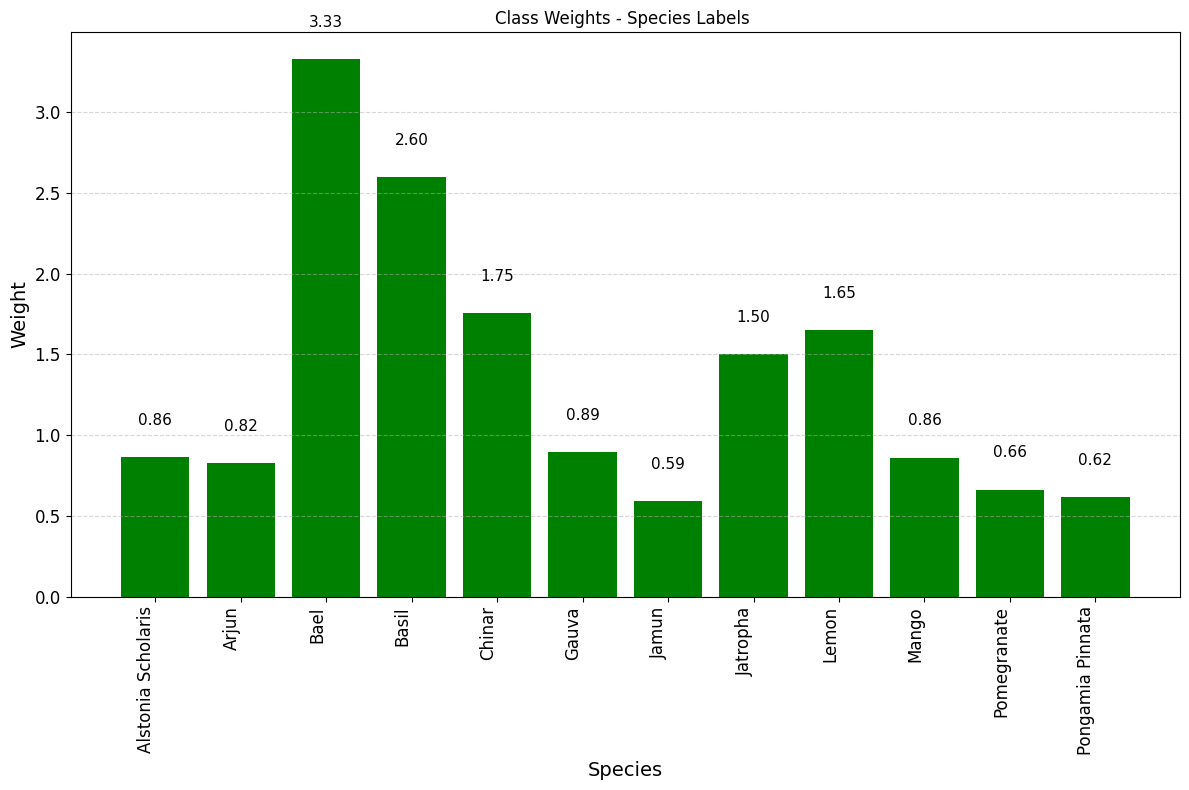

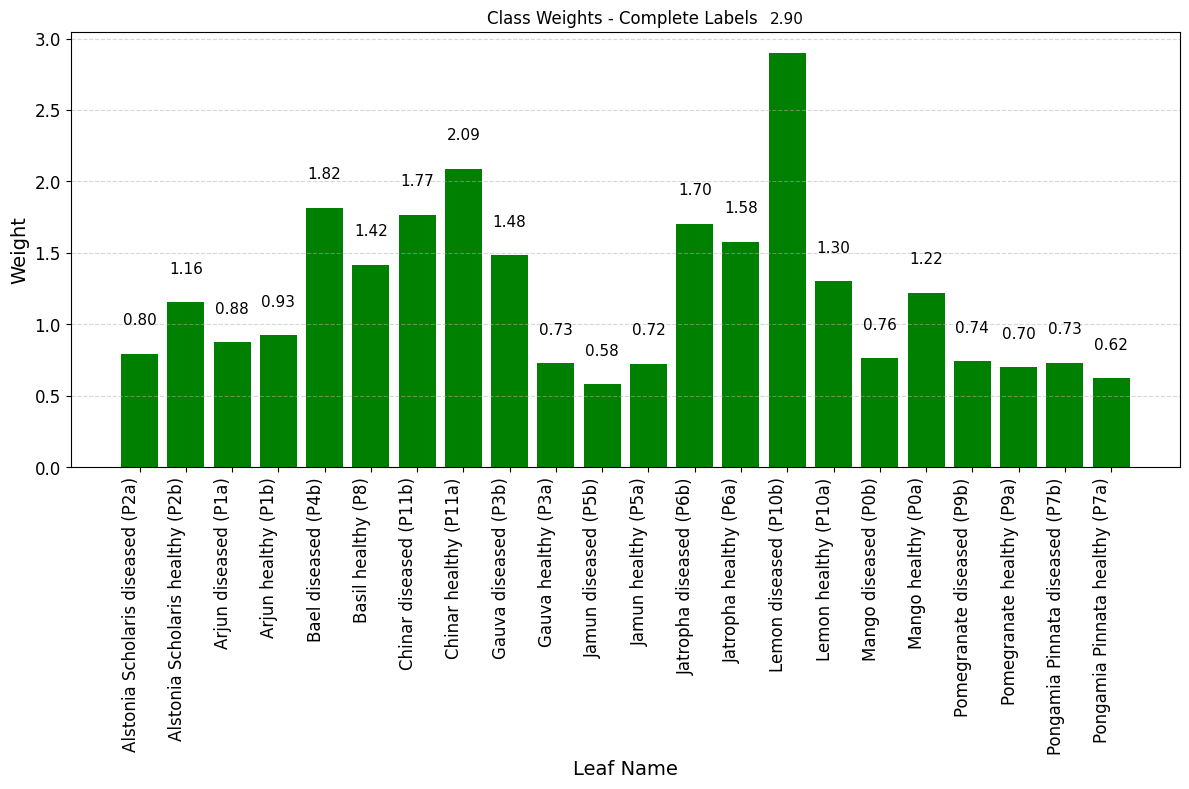

In [55]:
leaf_names = list(class_weights_species.keys())
weights = list(class_weights_species.values())

plt.figure(figsize=(12, 8))
plt.bar(leaf_names, weights, color='green')
plt.xlabel('Species', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Class Weights - Species Labels ', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add data labels above each bar
for i, v in enumerate(weights):
    plt.text(i, v + 0.2, f'{v:.2f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()


########
complete_names = list(class_weights_complete.keys())
weights = list(class_weights_complete.values())

plt.figure(figsize=(12, 8))
plt.bar(complete_names, weights, color='green')
plt.xlabel('Leaf Name', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Class Weights - Complete Labels ', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add data labels above each bar
for i, v in enumerate(weights):
    plt.text(i, v + 0.2, f'{v:.2f}', ha='center', fontsize=11)

plt.tight_layout()

plt.savefig('fra.png', dpi=300)
plt.show()

### Plant leaves images

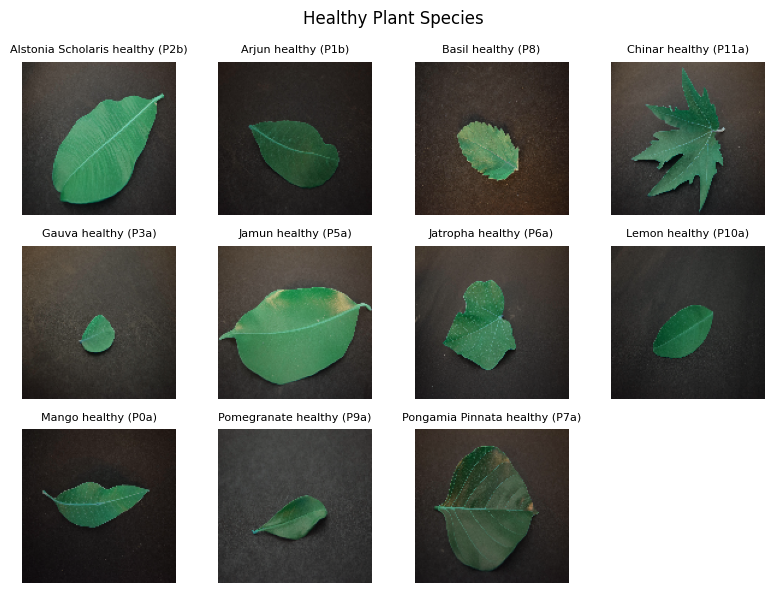

In [17]:
# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 4

# Define the labels for the healthy species
healthy_species_labels = ['Alstonia Scholaris healthy (P2b)', 'Arjun healthy (P1b)', 'Basil healthy (P8)', 'Chinar healthy (P11a)', 'Gauva healthy (P3a)', 'Jamun healthy (P5a)', 'Jatropha healthy (P6a)', 'Lemon healthy (P10a)', 'Mango healthy (P0a)', 'Pomegranate healthy (P9a)', 'Pongamia Pinnata healthy (P7a)']

# Calculate the actual number of images based on the available data
num_images = min(len(healthy_species_labels), num_rows * num_cols)

# Calculate the number of empty subplots
num_empty_subplots = (num_rows * num_cols) - num_images

# Define the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Plot the healthy species images
for i, label in enumerate(healthy_species_labels[:num_images]):
    images = X_train[y_train_complete == label]
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(images[0])  # Plot the first image for each species
    ax.set_title(label, fontsize=8)  # Reduce the size of the labels
    ax.axis('off')

# Remove the empty subplots
for i in range(num_empty_subplots):
    fig.delaxes(axes.flatten()[num_images + i])

# Add a title to the plot
plt.suptitle('Healthy Plant Species', fontsize=12)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

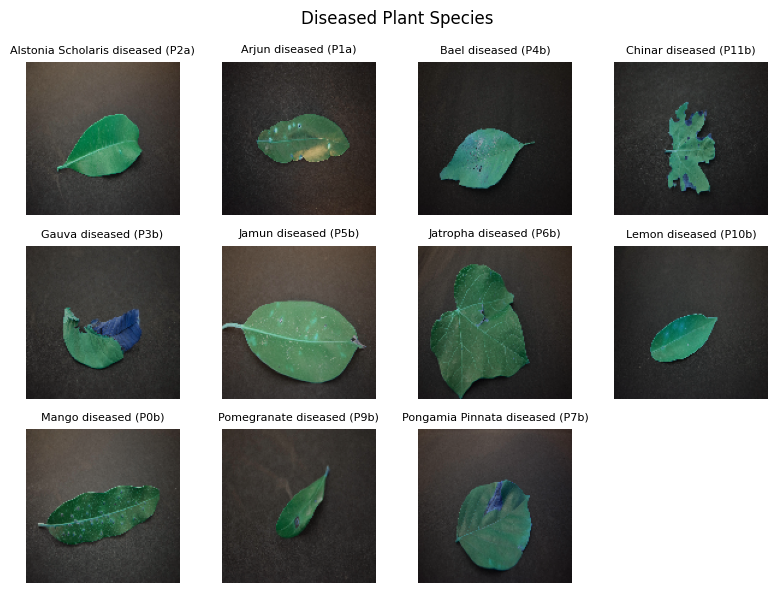

In [18]:
# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 4

# Define the labels for the diseased species
diseased_species_labels = ['Alstonia Scholaris diseased (P2a)', 'Arjun diseased (P1a)', 'Bael diseased (P4b)', 'Chinar diseased (P11b)', 'Gauva diseased (P3b)', 'Jamun diseased (P5b)', 'Jatropha diseased (P6b)', 'Lemon diseased (P10b)', 'Mango diseased (P0b)', 'Pomegranate diseased (P9b)', 'Pongamia Pinnata diseased (P7b)']

# Calculate the actual number of images based on the available data
num_images = min(len(diseased_species_labels), num_rows * num_cols)

# Calculate the number of empty subplots
num_empty_subplots = (num_rows * num_cols) - num_images

# Define the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Plot the diseased species images
for i, label in enumerate(diseased_species_labels[:num_images]):
    images = X_train[y_train_complete == label]
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(images[0])  # Plot the first image for each species
    ax.set_title(label, fontsize=8)  # Reduce the size of the labels
    ax.axis('off')

# Remove the empty subplots
for i in range(num_empty_subplots):
    fig.delaxes(axes.flatten()[num_images + i])

# Add a title to the plot
plt.suptitle('Diseased Plant Species', fontsize=12)

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

#Convolutional Neural Networks (CNNs)

CNNs are used for three specific classification tasks in this project. Each task focuses on different categories:
* Binary Classification: The CNN is trained to classify leaves as either healthy or diseased. The labels are one-hot encoded to represent the two classes.
* Multiclass Species Classification: The CNN is trained to classify leaves into 12 different species, such as Mango, Basil, Chinar, and more. The labels are one-hot encoded to represent the 12 classes.
* Multiclass Complete Classification: The CNN is trained to classify leaves based on 22 complete names given to the images, such as "Mango healthy" or "Arjun diseased." The labels are one-hot encoded to represent the 22 classes.

## **Hot encoding**

In [19]:
# One-hot encodinf of binary labels y_test_binary
y_train_binary_encoded = to_categorical(y_train_binary)
y_test_binary_encoded = to_categorical(y_test_binary)
y_valid_binary_encoded = to_categorical(y_valid_binary)

In [20]:
##ONE-HOT ENCODING OF MULTIPLE LABELS (12 SPECIES)
label_mapping = {'Alstonia Scholaris': 0,
              'Arjun': 1,
              'Bael': 2,
              'Basil': 3,
              'Chinar': 4,
              'Gauva': 5,
              'Jamun': 6,
              'Jatropha': 7,
              'Lemon': 8,
              'Mango': 9,
              'Pomegranate': 10,
              'Pongamia Pinnata': 11}

# Map string labels to integer values
y_train_mapped = [label_mapping[label] for label in y_train_species]
y_test_mapped = [label_mapping[label] for label in y_test_species]
y_valid_mapped = [label_mapping[label] for label in y_valid_species]

# Convert mapped labels to one-hot encoded format
y_train_species_encoded = to_categorical(y_train_mapped, 12)
y_test_species_encoded = to_categorical(y_test_mapped, 12)
y_valid_species_encoded = to_categorical(y_valid_mapped, 12)

In [21]:
##ONE-HOT ENCODING OF 22 COMPLETE NAMES
label_mapping = {'Alstonia Scholaris diseased (P2a)': 0,
              'Alstonia Scholaris healthy (P2b)': 1,
              'Arjun diseased (P1a)': 2,
              'Arjun healthy (P1b)': 3,
              'Bael diseased (P4b)': 4,
              'Basil healthy (P8)': 5,
              'Chinar diseased (P11b)': 6,
              'Chinar healthy (P11a)': 7,
              'Gauva diseased (P3b)': 8,
              'Gauva healthy (P3a)': 9,
              'Jamun diseased (P5b)': 10,
              'Jamun healthy (P5a)': 11,
              'Jatropha diseased (P6b)': 12,
              'Jatropha healthy (P6a)': 13,
              'Lemon diseased (P10b)': 14,
              'Lemon healthy (P10a)': 15,
              'Mango diseased (P0b)': 16,
              'Mango healthy (P0a)': 17,
              'Pomegranate diseased (P9b)': 18,
              'Pomegranate healthy (P9a)': 19,
              'Pongamia Pinnata diseased (P7b)': 20,
              'Pongamia Pinnata healthy (P7a)': 21}

# Map string labels to integer values
y_train_mapped = [label_mapping[label] for label in y_train_complete]
y_test_mapped = [label_mapping[label] for label in y_test_complete]
y_valid_mapped = [label_mapping[label] for label in y_valid_complete]

# Convert mapped labels to one-hot encoded format
y_train_complete_encoded = to_categorical(y_train_mapped, 22)
y_test_complete_encoded = to_categorical(y_test_mapped, 22)
y_valid_complete_encoded = to_categorical(y_valid_mapped, 22)

## **CNNs architecture, training, validation and test**
In this section, we will explore different hyperparameters, such as batch size, number of epochs and optimizers, in the context of CNN architecture for leaf classification. The CNN architecture remains the same for all three classification tasks, but the output layer is adapted based on the specific classification task's requirements, including the activation function and the number of output units. To achieve the best performance and accuracy, we experiment with different batch sizes (32, 64), epochs (30, 50) and optimizers (Adam, SGD).

##**Hyperparameter tuning with CridSearchCV**
Hyperparameter tuning is the process of finding the optimal hyperparameters for a machine learning model. In this project, a grid search cross-validation is set to perform hyperparameter tuning. Grid search exhaustively searches through a specified hyperparameter grid and evaluates each combination using cross-validation. It trains and evaluates the model with different hyperparameter values to find the best combination that maximizes a chosen evaluation metric (i.e., accuracy). Grid search is useful because it automates the process of finding the best hyperparameters by systematically exploring the entire search space. Instead of manually trying different combinations, grid search provides an efficient way to compare and evaluate different models based on their performance. It helps in identifying the hyperparameters that result in the best model performance and can lead to improved accuracy and generalization of the model. By tuning the hyperparameters, we can optimize the model's performance and prevent issues such as overfitting or underfitting. It allows us to find the best configuration for the given dataset and problem, ultimately improving the model's ability to make accurate predictions on unseen data.

**GridSearchCV**

In the context of hyperparameter tuning, "GridSearchCV" stands for *Grid Search Cross-Validation*. "CV" refers to cross-validation, which is a technique used to assess the performance of a machine learning model on unseen data. The "cv=3" parameter in GridSearchCV indicates that we are using 3-fold cross-validation. Cross-validation involves dividing the available data into k subsets or folds. In the case of 3-fold cross-validation, the data is split into three equal parts.  The GridSearchCV algorithm then performs a search over the specified hyperparameter grid, training and evaluating the model using each combination of hyperparameters. For each combination, it trains the model on two folds and evaluates it on the remaining fold. This process is repeated three times, with each fold serving as the validation set once. The performance metrics, such as accuracy or loss, are averaged across the three iterations to give an overall assessment of the model's performance. Using cross-validation helps to provide a more reliable estimate of the model's performance by reducing the impact of variability in the data and ensuring that the evaluation is not biased towards a particular subset of the data. It helps to assess how well the model is expected to generalize to unseen data by simulating the process of training and testing on multiple independent subsets of the data.

In [22]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

###**BINARY CLASSIFICATION**
The CNN below aims at classifying images of plant leaves according to their state of health (diseased or healthy). The activation function in the. final dense layer is Sigmoid.




In [23]:
def train_binary_model(batch_size, epochs, optimizer):
    # Create and compile the model
    model_binary = Sequential([
        Conv2D(8, (3,3), input_shape=(128, 128, 3), activation='relu'),
        MaxPooling2D((3,3)),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(32, activation="relu"),
        Dense(2, activation='sigmoid')
    ])
    model_binary.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history_binary = model_binary.fit(X_train, y_train_binary_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, y_valid_binary_encoded))

    return model_binary

**HYPERPARAMETER TUNING**

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [30, 50],
    'optimizer': ['adam', 'sgd']
}

# Create the model
model_binary = KerasClassifier(build_fn=train_binary_model)

# Create the GridSearchCV object
grid_binary = GridSearchCV(estimator=model_binary, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_binary.fit(X_train, y_train_binary_encoded)

# Get the best parameters and best score
best_params = grid_binary.best_params_
best_score = grid_binary.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# The "Best Score" represents the average performance of the model across
#all cross-validation folds using the specified scoring metric (the default is accuracy)

The **"Best Score"** represents the average performance of the model across all cross-validation folds using the specified scoring metric (the default one - if not specified - is the accuracy). The code below retrieves the cross-validation results from the GridSearchCV object and prints the validation scores along with their standard deviations for each combination of hyperparameters.

In [25]:
# print results
print(f'Best score for {grid_binary.best_score_} using {grid_binary.best_params_}')
means = grid_binary.cv_results_['mean_test_score']
stds = grid_binary.cv_results_['std_test_score']
params = grid_binary.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best score for 0.962330957253774 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.9331, std=0.006112 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.7368, std=0.05341 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.9623, std=0.004662 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.8622, std=0.006555 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'sgd'}
 mean=0.8912, std=0.01762 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.6977, std=0.06663 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.9286, std=0.01424 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.7475, std=0.05529 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'sgd'}


**PLOT TRAIN-VALIDATION ACCURACY AND LOSS CURVES OF BEST MODEL**

In [ ]:
# Train the best binary model
best_binary_model = train_binary_model(best_params['batch_size'], best_params['epochs'], best_params['optimizer'])

Training Accuracy: 0.9983621835708618
Training Loss: 0.011223502457141876
Validation Accuracy: 0.8999999761581421
Validation Loss: 0.5420950055122375


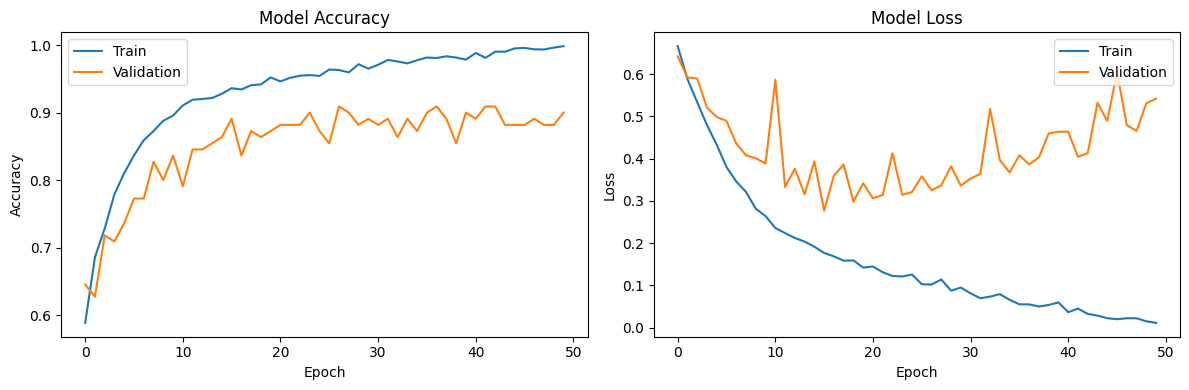

In [60]:
# Get the history object of the best binary model
history_best_binary = best_binary_model.history

# Plot the accuracy and loss curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot train and validation accuracy
axs[0].plot(history_best_binary.history['accuracy'])
axs[0].plot(history_best_binary.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot train and validation loss
axs[1].plot(history_best_binary.history['loss'])
axs[1].plot(history_best_binary.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.tight_layout()

# Print the accuracy and loss values
train_accuracy = history_best_binary.history['accuracy'][-1]
train_loss = history_best_binary.history['loss'][-1]
val_accuracy = history_best_binary.history['val_accuracy'][-1]
val_loss = history_best_binary.history['val_loss'][-1]

# Print the accuracy and loss values
print("Training Accuracy:", train_accuracy)
print("Training Loss:", train_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)


**TESTING THE BINARY MODELS**

In [28]:
# Get the best model from GridSearchCV
best_model_binary = grid_binary.best_estimator_.model

# Evaluate the best model on the test set
test_loss, test_acc = best_model_binary.evaluate(X_test, y_test_binary_encoded)

# Print the test accuracy and loss
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

4/4 [==============================] - 0s 6ms/step - loss: 0.3772 - accuracy: 0.9455
Test Accuracy: 0.9454545378684998
Test Loss: 0.3772112727165222


**OTHER EVALUATION METRICS AND CONFUSION MATRIX**

4/4 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        55
           1       0.96      0.93      0.94        55

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110



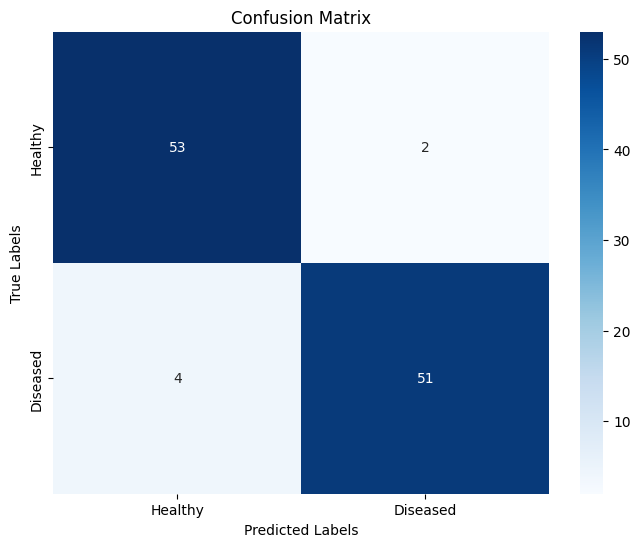

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set using the best model
y_pred = best_model_binary.predict(X_test)

# Convert probability predictions to class labels if needed
y_pred_binary = np.argmax(y_pred, axis=1)

# Compute classification report
report = classification_report(y_test_binary, y_pred_binary)

# Print the classification report
print("Classification Report:")
print(report)

# Create the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Define the class labels
labels = ["Healthy", "Diseased"]

# Plot the confusion matrix as a heatmap with blue shades
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### **12 SPECIES CLASSIFICATION**
The CNN below aims at classifying images of plant leaves according to the 12 species. To this aim, the chosen activation function is Softmax, the loss function is the Categorical Cross-Entropy.

In [30]:
def train_species_model(batch_size, epochs, optimizer):
    # Create and compile the model
    model_species = Sequential([
        Conv2D(8, (3,3), input_shape=(128, 128, 3), activation='relu'),
        MaxPooling2D((3,3)),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(32, activation="relu"),
        Dense(12, activation='softmax')
    ])
    model_species.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_species = model_species.fit(X_train, y_train_species_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, y_valid_species_encoded))

    return model_species

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [30, 50],
    'optimizer': ['adam', 'sgd']
}

# Create the model
model_species = KerasClassifier(build_fn=train_species_model)

# Create the GridSearchCV object
grid_species = GridSearchCV(estimator=model_species, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_species.fit(X_train, y_train_species_encoded)

# Get the best parameters and best score
best_params = grid_species.best_params_
best_score = grid_species.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [32]:
# print results
print(f'Best score for {grid_species.best_score_} using {grid_species.best_params_}')
means = grid_species.cv_results_['mean_test_score']
stds = grid_species.cv_results_['std_test_score']
params = grid_species.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best score for 0.3294753432273865 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.3178, std=0.1402 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.0543, std=0.05487 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.3295, std=0.1481 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.1549, std=0.09637 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'sgd'}
 mean=0.223, std=0.05354 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.08329, std=0.04928 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.2611, std=0.118 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.1011, std=0.0542 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'sgd'}


**PLOT ACCURACY AND LOSS OF THE BEST MODEL**

In [ ]:
# Train the best binary model
best_species_model = train_species_model(best_params['batch_size'], best_params['epochs'], best_params['optimizer'])

Training Accuracy: 0.9775385856628418
Training Loss: 0.07029971480369568
Validation Accuracy: 0.8454545736312866
Validation Loss: 0.601776123046875


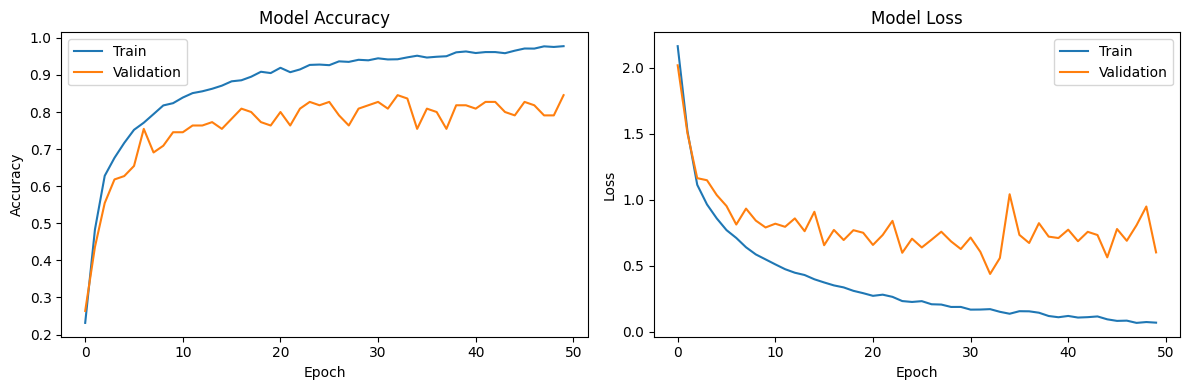

In [68]:
# Get the history object of the best binary model
history_best_species = best_species_model.history

# Plot the accuracy and loss curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot train and validation accuracy
axs[0].plot(history_best_species.history['accuracy'])
axs[0].plot(history_best_species.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot train and validation loss
axs[1].plot(history_best_species.history['loss'])
axs[1].plot(history_best_species.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.tight_layout()

# Print the accuracy and loss values
train_accuracy = history_best_species.history['accuracy'][-1]
train_loss = history_best_species.history['loss'][-1]
val_accuracy = history_best_species.history['val_accuracy'][-1]
val_loss = history_best_species.history['val_loss'][-1]

# Print the accuracy and loss values
print("Training Accuracy:", train_accuracy)
print("Training Loss:", train_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

# Show the plot
plt.show()

**TEST THE BEST MODEL ON TEST SET**

In [69]:
# Get the best model from GridSearchCV
best_model_species = grid_species.best_estimator_.model

# Evaluate the best model on the test set
test_loss, test_acc = best_model_species.evaluate(X_test, y_test_species_encoded)

# Print the test accuracy and loss
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

4/4 [==============================] - 0s 6ms/step - loss: 0.9084 - accuracy: 0.8273
Test Accuracy: 0.8272727131843567
Test Loss: 0.9083957076072693


**OTHER EVALUATION METRICS AND CONFUSION MATRIX**

4/4 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.91      1.00      0.95        10
           2       1.00      0.80      0.89         5
           3       0.71      1.00      0.83         5
           4       0.82      0.90      0.86        10
           5       0.78      0.70      0.74        10
           6       0.62      1.00      0.77        10
           7       1.00      0.70      0.82        10
           8       0.90      0.90      0.90        10
           9       0.89      0.80      0.84        10
          10       1.00      0.90      0.95        10
          11       0.62      0.50      0.56        10

    accuracy                           0.83       110
   macro avg       0.85      0.83      0.83       110
weighted avg       0.84      0.83      0.83       110



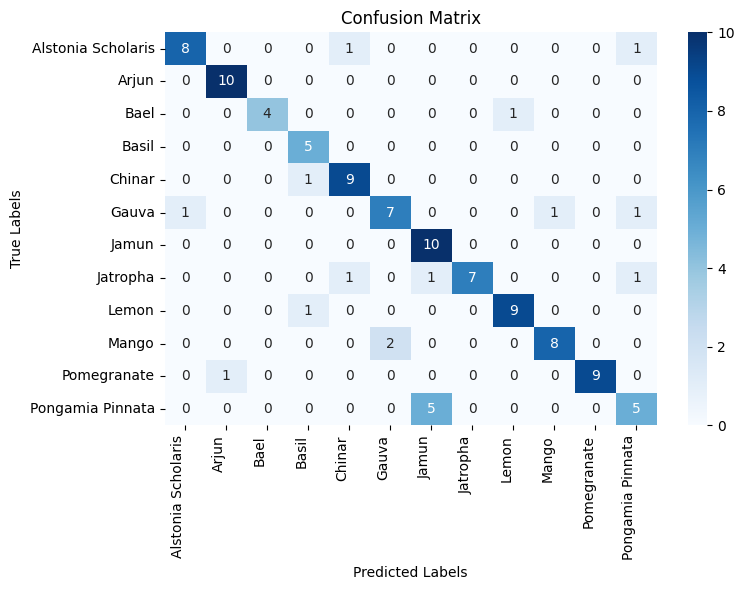

In [70]:
# Make predictions on the test set using the best model
y_pred = best_model_species.predict(X_test)

# Convert probability predictions to class labels
y_pred_species = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to single-label format
y_test_species_single = np.argmax(y_test_species_encoded, axis=1)

# Compute classification report
report = classification_report(y_test_species_single, y_pred_species)

# Print the classification report
print("Classification Report:")
print(report)

# Create the confusion matrix
cm = confusion_matrix(y_test_species_single, y_pred_species)

# Plot the confusion matrix as a heatmap with blue shades
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=species_list, yticklabels=species_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **22 CATEGORIES CLASSIFICATION**
The CNN below aims at classifying images of plant leaves according to the 22 complete names of leaves. To this aim, the chosen activation function is Softmax, the loss function is the Categorical Cross-Entropy.

In [36]:
def train_complete_model(batch_size, epochs, optimizer):
    # Create and compile the model
    model_complete = Sequential([
        Conv2D(8, (3,3), input_shape=(128, 128, 3), activation='relu'),
        MaxPooling2D((3,3)),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(32, activation="relu"),
        Dense(22, activation='softmax')
    ])
    model_complete.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_complete = model_complete.fit(X_train, y_train_complete_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, y_valid_complete_encoded))

    return model_complete

**TRAIN MODELS WITH DIFFERENT HYPERPARAMETERS AND OPTIMIZERS**

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'batch_size': [32, 64],
    'epochs': [30, 50],
    'optimizer': ['adam', 'sgd']
}

# Create the model
model_complete = KerasClassifier(build_fn=train_complete_model)

# Create the GridSearchCV object
grid_complete = GridSearchCV(estimator=model_complete, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_complete.fit(X_train, y_train_complete_encoded)

# Get the best parameters and best score
best_params = grid_complete.best_params_
best_score = grid_complete.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [ ]:
# print results
print(f'Best score for {grid_complete.best_score_} using {grid_complete.best_params_}')
means = grid_species.cv_results_['mean_test_score']
stds = grid_species.cv_results_['std_test_score']
params = grid_species.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best score for 0.31401849289735156 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.2221, std=0.08154 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.08212, std=0.0541 using {'batch_size': 32, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.3835, std=0.08919 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.157, std=0.04684 using {'batch_size': 32, 'epochs': 50, 'optimizer': 'sgd'}
 mean=0.1797, std=0.11 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'adam'}
 mean=0.08329, std=0.04564 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'sgd'}
 mean=0.3112, std=0.02835 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
 mean=0.1025, std=0.04221 using {'batch_size': 64, 'epochs': 50, 'optimizer': 'sgd'}


**PLOT THE BEST MODEL ACCURACY AND LOSS**

In [ ]:
# Train the best binary model
best_complete_model = train_complete_model(best_params['batch_size'], best_params['epochs'], best_params['optimizer'])

Training Accuracy: 0.9656059741973877
Training Loss: 0.11448115110397339
Validation Accuracy: 0.7181817889213562
Validation Loss: 1.6961705684661865


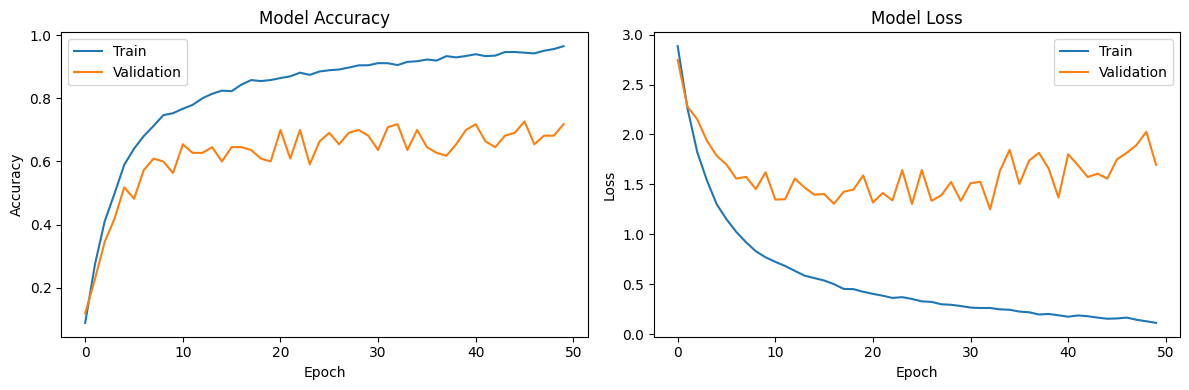

In [62]:
# Get the history object of the best binary model
history_best_complete = best_complete_model.history

# Plot the accuracy and loss curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot train and validation accuracy
axs[0].plot(history_best_complete.history['accuracy'])
axs[0].plot(history_best_complete.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot train and validation loss
axs[1].plot(history_best_complete.history['loss'])
axs[1].plot(history_best_complete.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.tight_layout()

# Print the accuracy and loss values
train_accuracy = history_best_complete.history['accuracy'][-1]
train_loss = history_best_complete.history['loss'][-1]
val_accuracy = history_best_complete.history['val_accuracy'][-1]
val_loss = history_best_complete.history['val_loss'][-1]

# Print the accuracy and loss values
print("Training Accuracy:", train_accuracy)
print("Training Loss:", train_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

# Show the plot
plt.show()

**TEST THE BEST MODEL ON THE TEST SET**

In [39]:
# Get the best model from GridSearchCV
best_model_complete = grid_complete.best_estimator_.model

# Evaluate the best model on the test set
test_loss, test_acc = best_model_complete.evaluate(X_test, y_test_complete_encoded)

# Print the test accuracy and loss
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

4/4 [==============================] - 0s 6ms/step - loss: 1.9495 - accuracy: 0.7909
Test Accuracy: 0.7909091114997864
Test Loss: 1.9495326280593872


**OTHER EVALUATION METRICS**

4/4 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.62      1.00      0.77         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       0.50      0.80      0.62         5
          11       0.12      0.20      0.15         5
          12       1.00      0.40      0.57         5
          13       0.60      0.60      0.60         5
          14       1.00      0.40      0.57         5
          15       0.62      1.00      0.77         5
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


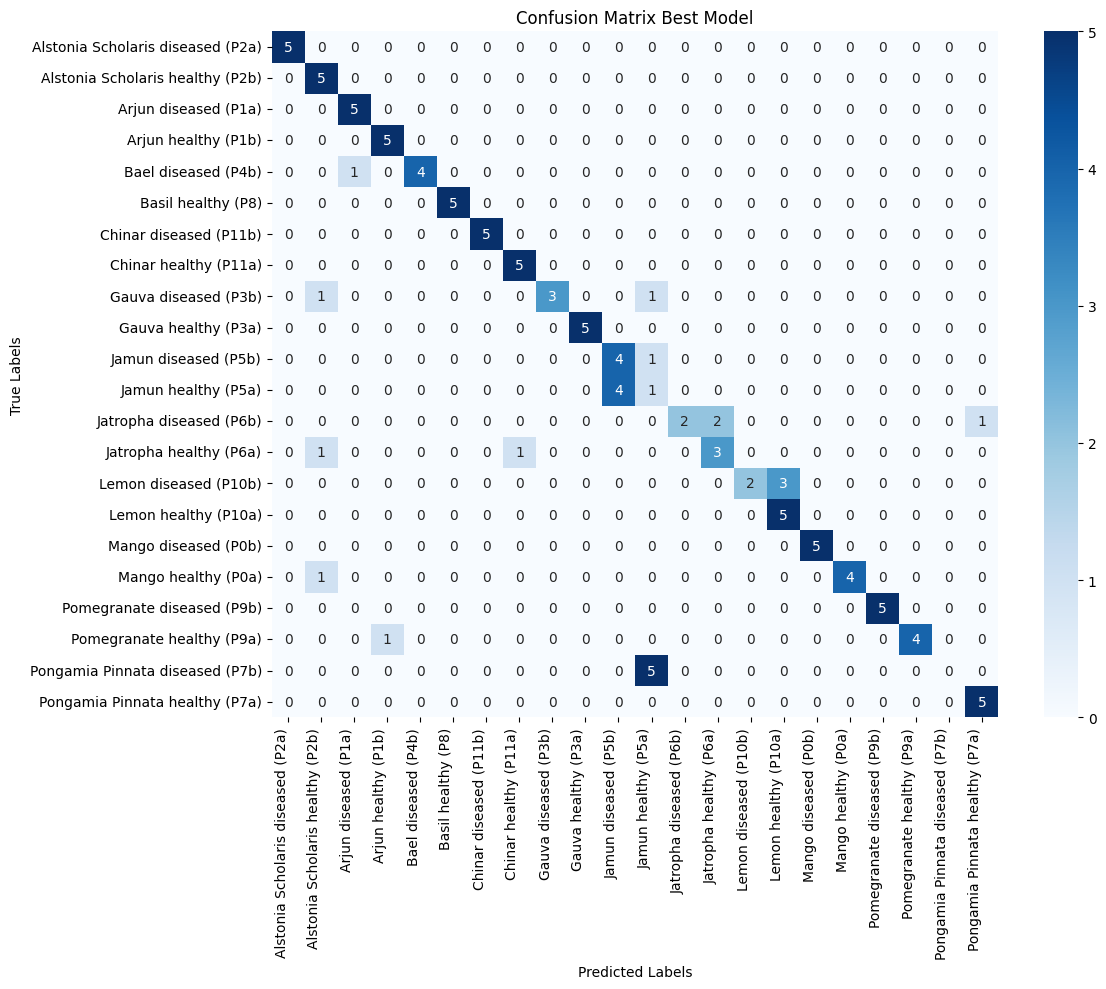

In [40]:
from sklearn.metrics import classification_report

# Make predictions on the test set using the best model
y_pred = best_model_complete.predict(X_test)

# Convert probability predictions to class labels
y_pred_complete = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to single-label format
y_test_complete_single = np.argmax(y_test_complete_encoded, axis=1)

# Compute classification report
report = classification_report(y_test_complete_single, y_pred_complete)

# Print the classification report
print("Classification Report:")
print(report)

# Create the confusion matrix
cm = confusion_matrix(y_test_complete_single, y_pred_complete)

# Plot the confusion matrix as a heatmap with blue shades
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=complete_names, yticklabels=complete_names)
plt.title('Confusion Matrix Best Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **Regularization layers and weights**
Applying some regularization layers in the CNNs can help improve their generalization performance and reduce overfitting. Common techniques include Dropout and BatchNormalization. The **Dropout layer** helps prevent overfitting by randomly dropping out a fraction of the input units during training, which helps to reduce the reliance of the model on specific features and encourages the learning of more robust representations. The **BatchNormalization layer** normalizes the activations of the previous layer, which helps in stabilizing the learning process and making the model more resilient to changes in the input distribution.

Furthermore, in the training and validation phase of the multiclass models are added the labels weights to tackle the problem of unbalanced data.

In [ ]:
#Binary classification with regularization layers
model_binary2 = Sequential([
    Conv2D(8, (3,3), input_shape=(128, 128, 3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(16, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.5),  # Add Dropout layer with a dropout rate of 0.5
    BatchNormalization(),  # Add BatchNormalization layer
    Dense(2, activation="sigmoid") #the number of units is 2 and use the Sigmoid function
])


model_binary2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_binary2 = model_binary2.fit(X_train, y_train_binary_encoded, batch_size=32, epochs=50, validation_data=(X_validation, y_valid_binary_encoded))

In [ ]:
#assign to each species the weight
weights_species = {0: 0.8644822006472492,
 1: 0.8244598765432098,
 2: 3.3286604361370715,
 3: 2.599756690997567,
 4: 1.7545155993431856,
 5: 0.894891122278057,
 6: 0.5906578220011056,
 7: 1.5028129395218002,
 8: 1.6489197530864197,
 9: 0.8603059581320451,
 10: 0.6620198265179678,
 11: 0.6172732524552282}

#Multiclass classification of the 12 labels with regularization layers
model_species2 = Sequential([
    Conv2D(8, (3,3), input_shape=(128, 128, 3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(16, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.5),  # Add Dropout layer with a dropout rate of 0.5
    BatchNormalization(),  # Add BatchNormalization layer
    Dense(12, activation="softmax")  # Update the number of units to 12 and use Softmax activation
])


model_species2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_species2 = model_species2.fit(X_train, y_train_species_encoded, class_weight=weights_species, batch_size=32, epochs=50, validation_data=(X_validation, y_valid_species_encoded))

In [ ]:
#assign to each leaf the weight
complete_weights = {0: 0.7961997019374069,
                  1: 1.1563852813852813,
                  2: 0.8751023751023751,
                  3: 0.9251082251082251,
                  4: 1.8156329651656755,
                  5: 1.418049104180491,
                  6: 1.7661157024793388,
                  7: 2.088954056695992,
                  8: 1.482997918112422,
                  9: 0.7276132107592782,
                  10: 0.5799185888738128,
                  11: 0.7248982360922659,
                  12: 1.70414673046252,
                  13: 1.5794530672579452,
                  14: 2.8995929443690636,
                  15: 1.303843807199512,
                  16: 0.7618538324420677,
                  17: 1.2218410520297314,
                  18: 0.744339951236503,
                  19: 0.7013455858221201,
                  20: 0.7331046312178388,
                  21: 0.6226689976689976}

#Multiclass classification of the 22 labels with regularization layers
model_complete2 = Sequential([
    Conv2D(8, (3,3), input_shape=(128, 128, 3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(16, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.5),  # Add Dropout layer with a dropout rate of 0.5
    BatchNormalization(),  # Add BatchNormalization layer
    Dense(22, activation="softmax")  # Update the number of units to 22 and use softmax activation
])

model_complete2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_complete2 = model_complete2.fit(X_train, y_train_complete_encoded, class_weight=complete_weights, batch_size=32, epochs=50, validation_data=(X_validation, y_valid_complete_encoded))

**PLOT TRAINING AND VALIDATION LOSS-ACCURACY CURVES**

Average Training Accuracy (Binary Classification): 0.9382498824596405
Average Training Loss (Binary Classification): 0.14697174344211816
Average Validation Accuracy (Binary Classification): 0.8554545438289642
Average Validation Loss (Binary Classification): 0.5143582284450531


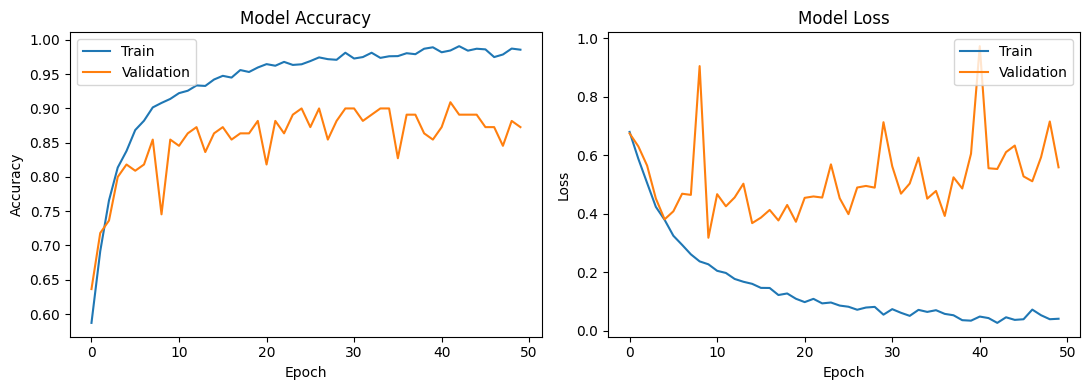

Average Training Accuracy (Species Classification): 0.6359195116162301
Average Training Loss (Species Classification): 1.0399234330654143
Average Validation Accuracy (Species Classification): 0.7356363594532013
Average Validation Loss (Species Classification): 0.8538018679618835


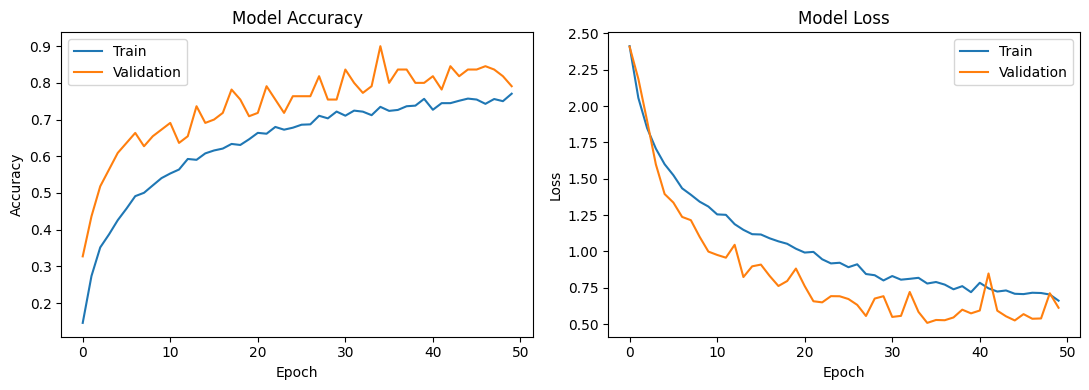

Average Training Accuracy (Complete Classification): 0.610594290047884
Average Training Loss (Complete Classification): 1.1832424104213715
Average Validation Accuracy (Complete Classification): 0.6325454510748386
Average Validation Loss (Complete Classification): 1.2020406651496887


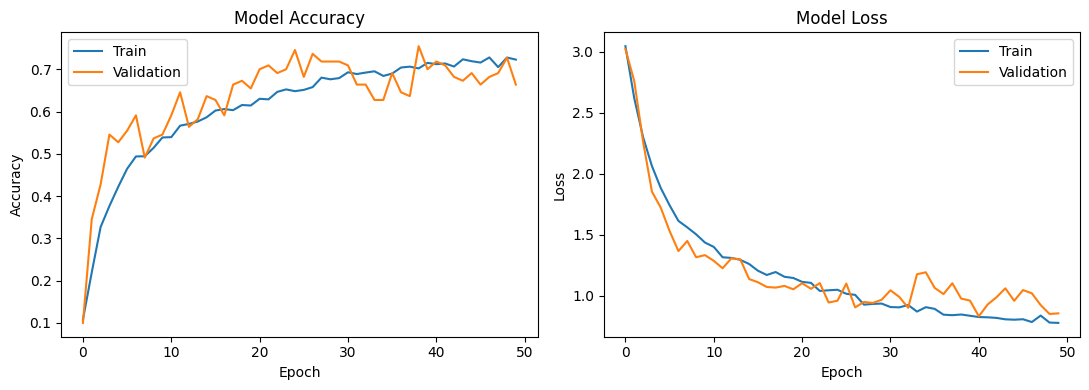

In [50]:
# Define the models and their corresponding names
models = [history_binary2, history_species2, history_complete2]
model_names = ['Binary Classification', 'Species Classification', 'Complete Classification']

# Iterate over the models
for i in range(len(models)):
    # Calculate the average training and validation metrics
    train_acc_avg = np.mean(models[i].history['accuracy'])
    train_loss_avg = np.mean(models[i].history['loss'])
    val_acc_avg = np.mean(models[i].history['val_accuracy'])
    val_loss_avg = np.mean(models[i].history['val_loss'])

    # Set the figure size
    plt.figure(figsize=(11, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(models[i].history['accuracy'])
    plt.plot(models[i].history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(models[i].history['loss'])
    plt.plot(models[i].history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the layout to make the plots closer horizontally
    plt.tight_layout()

    # Print the average training and validation metrics
    print("Average Training Accuracy (" + model_names[i] + "):", train_acc_avg)
    print("Average Training Loss (" + model_names[i] + "):", train_loss_avg)
    print("Average Validation Accuracy (" + model_names[i] + "):", val_acc_avg)
    print("Average Validation Loss (" + model_names[i] + "):", val_loss_avg)

    # Show the plots
    plt.show()


**TEST MODELS ON TEST SET**

In [51]:
# Evaluate the best model on the test set - Model 1 (Binary Classification)
test_loss_binary2, test_acc_binary2 = model_binary2.evaluate(X_test, y_test_binary_encoded)

# Evaluate the best model on the test set - Model 2 (Multiclass Species Classification)
test_loss_species2, test_acc_species2 = model_species2.evaluate(X_test, y_test_species_encoded)

# Evaluate the best model on the test set - Model 3 (Multiclass Complete Classification)
test_loss_complete2, test_acc_complete2 = model_complete2.evaluate(X_test, y_test_complete_encoded)

# Print the test accuracy and loss for each model
print("Test Accuracy - Model 1 (Binary Classification):", test_acc_binary2)
print("Test Loss - Model 1 (Binary Classification):", test_loss_binary2)
print("Test Accuracy - Model 2 (Multiclass Species Classification):", test_acc_species2)
print("Test Loss - Model 2 (Multiclass Species Classification):", test_loss_species2)
print("Test Accuracy - Model 3 (Multiclass Complete Classification):", test_acc_complete2)
print("Test Loss - Model 3 (Multiclass Complete Classification):", test_loss_complete2)

4/4 [==============================] - 0s 7ms/step - loss: 0.7746 - accuracy: 0.7727
Test Accuracy - Model 1 (Binary Classification): 0.8818181753158569
Test Loss - Model 1 (Binary Classification): 0.5416364073753357
Test Accuracy - Model 2 (Multiclass Species Classification): 0.8909090757369995
Test Loss - Model 2 (Multiclass Species Classification): 0.3215291500091553
Test Accuracy - Model 3 (Multiclass Complete Classification): 0.7727272510528564
Test Loss - Model 3 (Multiclass Complete Classification): 0.774594783782959


**OTHER METRICS AND CONFUSION MATRIX**

4/4 [==============================] - 0s 5ms/step
Classification Report (Binary Classification):
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        55
           1       0.88      0.89      0.88        55

    accuracy                           0.88       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110



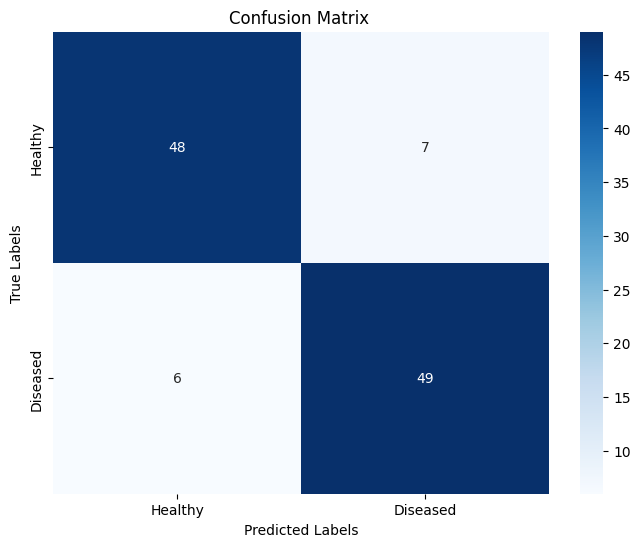

In [52]:
# Make predictions on the test set using model_binary2
y_pred_binary2 = model_binary2.predict(X_test)
y_pred_binary2 = np.argmax(y_pred_binary2, axis=1)

# Print the classification report for model_binary2
print("Classification Report (Binary Classification):")
report_binary2 = classification_report(y_test_binary, y_pred_binary2)
print(report_binary2)

# Create the confusion matrix
cm_binary2 = confusion_matrix(y_test_binary, y_pred_binary2)

# Define class labels
class_labels = ["Healthy", "Diseased"]

# Plot the confusion matrix as a heatmap with blue shades
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary2, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix ")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

4/4 [==============================] - 0s 4ms/step
Classification Report (Species Classification):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00         5
           3       0.71      1.00      0.83         5
           4       1.00      1.00      1.00        10
           5       0.80      0.80      0.80        10
           6       1.00      0.80      0.89        10
           7       0.89      0.80      0.84        10
           8       1.00      0.90      0.95        10
           9       1.00      0.90      0.95        10
          10       0.89      0.80      0.84        10
          11       0.69      0.90      0.78        10

   micro avg       0.89      0.89      0.89       110
   macro avg       0.90      0.90      0.89       110
weighted avg       0.90      0.89      0.89       110
 samples avg       0.89      0.89  

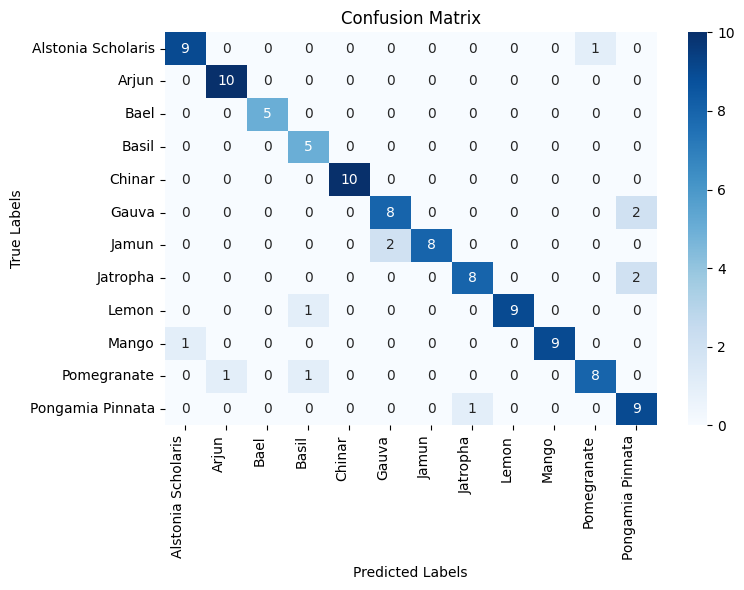

In [53]:
from sklearn.metrics import classification_report
from keras.utils import to_categorical

# Make predictions on the test set using model_species2
y_pred_species2 = model_species2.predict(X_test)
y_pred_species2 = np.argmax(y_pred_species2, axis=1)

# Convert y_pred_species2 to one-hot encoded format
y_pred_species2_encoded = to_categorical(y_pred_species2)

# Print the classification report for model_species2
print("Classification Report (Species Classification):")
report_species2 = classification_report(y_test_species_encoded, y_pred_species2_encoded)
print(report_species2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reverse the order of labels for plotting
#labels = ['Alstonia Scholaris', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']
y_test = np.argmax(y_test_species_encoded, axis=1)

# Confusion Matrix for Model 2
y_pred2 = model_species2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)
cm_species2 = confusion_matrix(y_test, y_pred2)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_species2, annot=True, cmap='Blues', fmt='d', xticklabels=species_list, yticklabels=species_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


4/4 [==============================] - 0s 5ms/step
Classification Report (Species Classification):
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      1.00      0.67         5
           2       1.00      0.40      0.57         5
           3       0.62      1.00      0.77         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.71      1.00      0.83         5
           7       1.00      0.80      0.89         5
           8       1.00      0.40      0.57         5
           9       1.00      1.00      1.00         5
          10       0.57      0.80      0.67         5
          11       0.38      0.60      0.46         5
          12       1.00      0.80      0.89         5
          13       0.57      0.80      0.67         5
          14       1.00      0.20      0.33         5
          15       0.62      1.00   

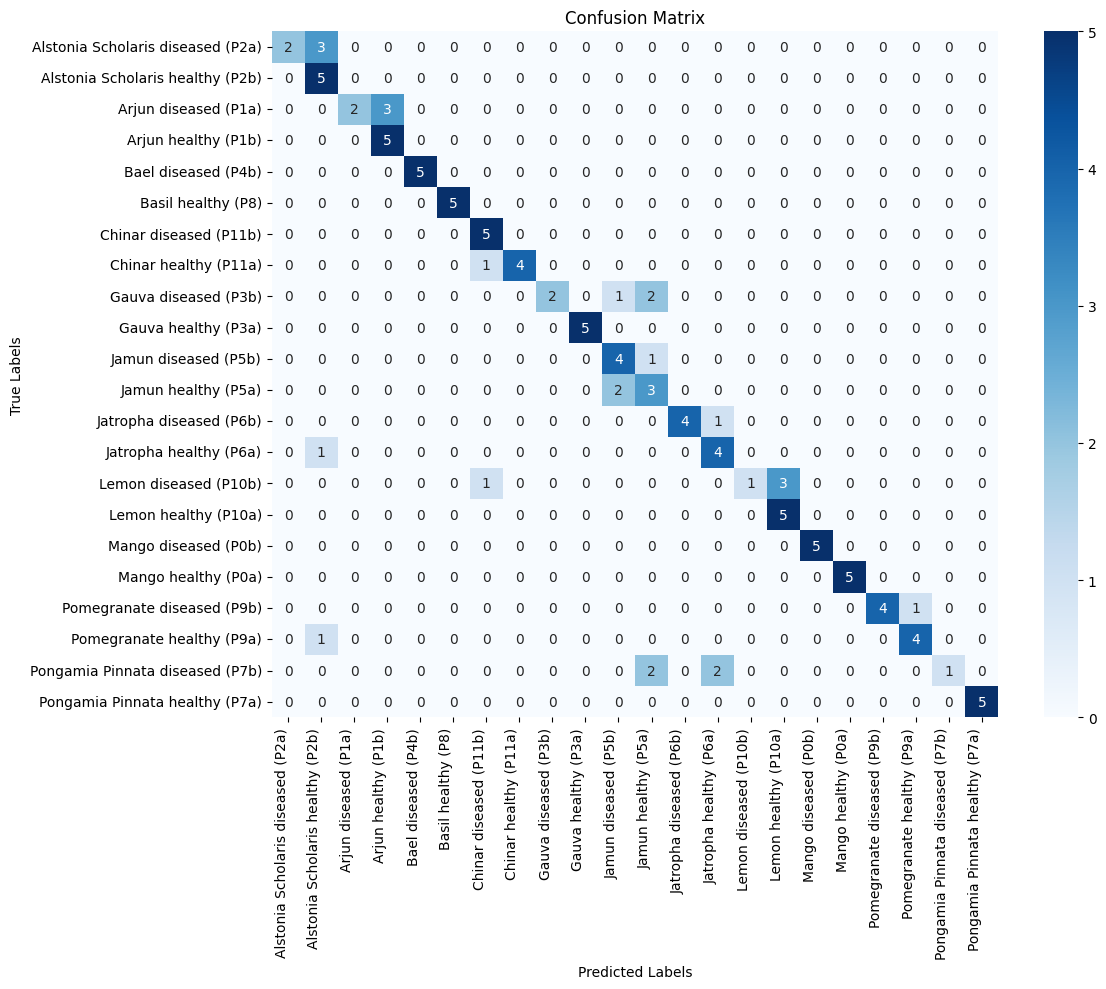

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

# Make predictions on the test set using model_complete2
y_pred_complete2 = model_complete2.predict(X_test)
y_pred_complete2 = np.argmax(y_pred_complete2, axis=1)

# Convert y_pred_complete2 to one-hot encoded format
y_pred_complete2_encoded = to_categorical(y_pred_complete2)

# Print the classification report for model_complete2
print("Classification Report (Species Classification):")
report_complete2 = classification_report(y_test_complete_encoded, y_pred_complete2_encoded)

# Print the classification report
print(report_complete2)

# Get the true labels
y_test = np.argmax(y_test_complete_encoded, axis=1)

# Compute the confusion matrix
cm_complete2 = confusion_matrix(y_test, y_pred_complete2)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_complete2, annot=True, cmap='Blues', fmt='d', xticklabels=complete_names, yticklabels=complete_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
